# Model Based Prediction and Control

### Sources:
- http://www.cs.uu.nl/docs/vakken/b2ki/LastYear/Docs/Slides/mdps-handouts.pdf
- https://towardsdatascience.com/how-to-code-the-value-iteration-algorithm-for-reinforcement-learning-8fb806e117d1
- https://artint.info/html/ArtInt_227.html

In [1]:
from typing import Tuple, List
import matplotlib.pyplot as plt
import numpy as np
import copy
import random

## Implementatie doolhof en agent

In [2]:
class Maze:
    def __init__(self, R: np.ndarray, end: List[Tuple[int, int]],
                 p_action: float = 0.7, discount: float = 0.9, threshold: float = 0.0001):
        """The init function.
        
        args:
            R (np.ndarray): The array with the rewards per state.
            end (List[Tuple[int, int]]): A list with the positions of the end states.
            p_action (float, optional): The probability of a succesfull action. Defaults to 0.7.
            discount (float, optional): The discount factor. Defaults to 0.9.
            threshold (float, optional): The threshold to be used for value iteration. Defaults to 0.0001.
        """
        self.R = R
        self.utility = np.zeros(R.shape)
        self.end_states = end

        self.p_action = p_action
        self.discount = discount
        self.threshold = threshold
    
    def __calc_action_value(self, action, other_actions) -> float:
        """Calculates the action value of a certain action with the succesfullness probability of the actions."""
        total_value = self.p_action * (self.R[action] + (self.discount * self.utility[action]))
        
        dist_chance = (1 - self.p_action) / len(other_actions)
        
        for noise_action in other_actions:
            total_value += dist_chance * (self.R[noise_action] + (self.discount * self.utility[noise_action]))
        return total_value
    
    def __get_action_positions(self, current_pos: Tuple[int, int]) -> Tuple[Tuple[int, int], Tuple[int, int], Tuple[int, int], Tuple[int, int]]:
        """Gets the next position for each action on a certain state.
        
        args:
            current_pos (Tuple[int, int]): The position for which the positions of the next actions should be returned.

        returns:
            Tuple[Tuple[int, int], Tuple[int, int], Tuple[int, int], Tuple[int, int]]: The next positions after the actions.
        """
        row, col = current_pos

        up = (row - 1, col) if row - 1 >= 0 else current_pos
        right = (row, col + 1) if col + 1 < self.R.shape[1] else current_pos
        left = (row, col -1) if col - 1 >= 0 else current_pos
        down = (row + 1, col) if row + 1 < self.R.shape[0] else current_pos
        return up, right, left, down
    
    def get_greedy_policy(self, current_pos: Tuple[int, int]) -> List[int]:
        """Gets the best policy based on greediness for each state.
        
        args:
            current_pos (Tuple[int, int]): The state for which the policy should be calculated.

        returns:
            List[int]: The actions to take based on the calculated policy.
        """
        actions = self.__get_action_positions(current_pos)
        action_values = []
        for index, action in enumerate(actions):
            noise_actions = actions[:index] + actions[index+1:]
            action_values.append(self.__calc_action_value(action, noise_actions))

        # get the index of the max elements 
        max_elem = max(action_values)
        return [1 if i == max_elem else 0 for i in action_values]
    
    def value_iteration(self):
        """Value iteration method."""
        delta = np.inf
        # get all positions in the grid
        positions = [(i,j) for i in range(self.R.shape[0]) for j in range(self.R.shape[1])]
        
        while delta > self.threshold:
            delta = 0
            new_utility = np.zeros(self.utility.shape)
            for pos in positions:
                # check if we are evaluating an end state
                if pos in self.end_states:
                    # current position is an end-state so value is 0
                    continue

                # save the current value
                value = self.utility[pos]
                # get the next positions of all the actions that can be taken on the current positions
                actions = self.__get_action_positions(pos)
                action_values = []
                for index, action in enumerate(actions):
                    noise_actions = actions[:index] + actions[index+1:]
                    action_values.append(self.__calc_action_value(action, noise_actions))
                
                # select the action with the highest utility
                highest_utility = max(action_values)
                new_utility[pos] = highest_utility
                # update the delta
                delta = max(delta, abs(value - highest_utility))
            
            self.utility = copy.deepcopy(new_utility)
    
    def show_utility(self):
        """Prints the utility array to the screen."""
        for row in range(self.utility.shape[0]):
            print("-------------------------------------")
            out = "| "
            for col in range(self.utility.shape[1]):
                out += str(round(self.utility[(row, col)], 2)).ljust(6) + ' | '
            print(out)
        print("-------------------------------------")
    
    def show_policy(self):
        """Calculates and prints the policy in a matplotlib figure."""
        for row in range(self.utility.shape[0]):
            for col in range(self.utility.shape[1]):
                # set the x and y value for the place of the state in the figure
                x, y = (col, self.utility.shape[1] - row)
                if (row, col) in self.end_states:
                    # end state so draw a point
                    plt.scatter(x, y, s=40)
                else:
                    policy = self.get_greedy_policy((row, col))
                    for action, direction in zip(policy, ["up", "right", "left", "down"]):
                        if action:
                            # draw an arrow in a direction based on the returned best greedy action
                            if direction == "up":
                                plt.arrow(x, y, dx=0, dy=0.2, width=0.06)
                            if direction == "right":
                                plt.arrow(x, y, dx=0.2, dy=0, width=0.06)
                            if direction == "left":
                                plt.arrow(x, y, dx=-0.2, dy=0, width=0.06)
                            if direction == "down":
                                plt.arrow(x, y, dx=0, dy=-0.2, width=0.06)
        plt.axis("off")
        plt.show()

In [3]:
class Agent:
    def __init__(self, pos: Tuple[int, int], model: Maze):
        """The init function.
        
        args:
            pos (Tuple[int, int]): The start state in the environment.
            model (Maze): The model which the agent will traverse.
        """
        self.pos = pos
        self.env = model
        self.actions = ["up", "right", "left", "down"]
    
    def greedy_traversal(self):
        """Uses the utility and rewards to greedily traverse the environment."""
        while self.pos not in self.env.end_states:
            actions = self.env.get_greedy_policy(self.pos)
            action = random.choice([j for i, j in zip(actions, self.actions) if i == 1])
            x, y = self.pos
            if action == "up":
                self.pos = (x - 1, y)
            elif action == "right":
                self.pos = (x, y + 1)
            elif action == "left":
                self.pos = (x, y - 1)
            else:
                self.pos = (x + 1, y)
            print(f"next_pos: {self.pos}; utility: {self.env.utility[self.pos]}; reward: {self.env.R[self.pos]}")
        

In [4]:
start_state = (3, 2)
terminal_states = [(0, 3), (3, 0)]

rewards = np.array([[-1, -1, -1, 40],
                    [-1, -1, -10, -10],
                    [-1, -1, -1, -1],
                    [10, -2, -1, -1]])

## Value iteration met deterministisch gedrag
Met een deterministische omgeving valt te zien dat de agent uiteindelijk linksom gaat (dus om de lake heen). De agent kan hiervoor kiezen aangezien er geen kans is dat hij, per ongeluk, afdwaald.

In [5]:
# build maze and agent
maze = Maze(rewards, terminal_states, discount=0.9, p_action=1.0, threshold=0.0001)
agent = Agent(start_state, maze)

maze.value_iteration()
maze.show_utility()

-------------------------------------
| 30.5   | 35.0   | 40.0   | 0.0    | 
-------------------------------------
| 26.45  | 30.5   | 35.0   | 40.0   | 
-------------------------------------
| 22.8   | 26.45  | 22.8   | 26.0   | 
-------------------------------------
| 0.0    | 22.8   | 19.52  | 22.4   | 
-------------------------------------


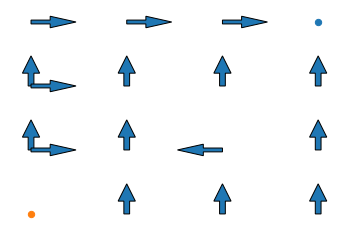

In [6]:
maze.show_policy()

In [7]:
agent.greedy_traversal()

next_pos: (2, 2); utility: 22.805; reward: -1
next_pos: (2, 1); utility: 26.45; reward: -1
next_pos: (1, 1); utility: 30.5; reward: -1
next_pos: (0, 1); utility: 35.0; reward: -1
next_pos: (0, 2); utility: 40.0; reward: -1
next_pos: (0, 3); utility: 0.0; reward: 40


## Value iteration met stochastisch gedrag
Met een stochastische omgeving valt te zien dat de agent via de rechterkant omhooggaat naar de uiteindelijke eindstate. Een reden hiervoor zou kunnen zijn dat de kans om linksom te gaan en af te dwalen groot genoeg is om voor zekerheid te kiezen en door een lake te gaan waarbij een flinke reductie in reward wordt afgenomen.

In [8]:
# build maze and agent
maze = Maze(rewards, terminal_states, discount=0.9, p_action=0.7, threshold=0.0001)
agent = Agent(start_state, maze)

maze.value_iteration()
maze.show_utility()

-------------------------------------
| 21.45  | 27.06  | 34.7   | 0.0    | 
-------------------------------------
| 17.1   | 20.39  | 25.97  | 32.74  | 
-------------------------------------
| 13.45  | 15.23  | 13.68  | 17.31  | 
-------------------------------------
| 0.0    | 11.61  | 10.72  | 13.26  | 
-------------------------------------


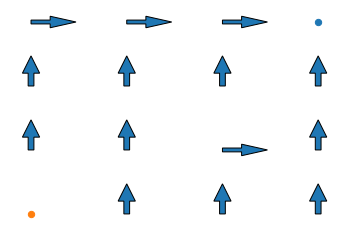

In [9]:
maze.show_policy()

In [10]:
agent.greedy_traversal()

next_pos: (2, 2); utility: 13.67819889239863; reward: -1
next_pos: (2, 3); utility: 17.309369174520658; reward: -1
next_pos: (1, 3); utility: 32.74204447002307; reward: -10
next_pos: (0, 3); utility: 0.0; reward: 40
